<a href="https://colab.research.google.com/github/bharathraj-v/geoml-wd/blob/main/notebooks/deeplabv3_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solar Panel Segmentation using DeepLabV3

#### Importing Libraries

In [1]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [2]:
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt

from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

from tensorflow.keras.applications import ResNet50

from keras.callbacks import Callback, ModelCheckpoint

from tensorflow.keras.utils import plot_model

from tf_explain.core.grad_cam import GradCAM

#### Loading and preparing the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!cp /content/drive/MyDrive/PV01.zip /content/
!unzip PV01.zip

In [5]:
brick = "PV01/PV01_Rooftop_Brick"
flatConcrete = "PV01/PV01_Rooftop_FlatConcrete"
steelTile = "PV01/PV01_Rooftop_SteelTile"



brick_paths = []
flatConcrete_paths = []
steelTile_paths = []

for root, dirs, files in os.walk(brick):
    for file in files:
        brick_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(flatConcrete):
    for file in files:
        flatConcrete_paths.append(os.path.join(root, file))

for root, dirs, files in os.walk(steelTile):
    for file in files:
        steelTile_paths.append(os.path.join(root, file))
     
brick_paths.sort()
flatConcrete_paths.sort()
steelTile_paths.sort()

brick_img, brick_label = [brick_paths[i] for i in range(0,len(brick_paths),2)], [brick_paths[i] for i in range(1,len(brick_paths),2)]
flatConcrete_img, flatConcrete_label = [flatConcrete_paths[i] for i in range(0,len(flatConcrete_paths),2)], [flatConcrete_paths[i] for i in range(1,len(flatConcrete_paths),2)]
steelTile_img, steelTile_label = [steelTile_paths[i] for i in range(0,len(steelTile_paths),2)], [steelTile_paths[i] for i in range(1,len(steelTile_paths),2)]

images = np.concatenate((brick_img, flatConcrete_img, steelTile_img))
masks = np.concatenate((brick_label,flatConcrete_label,steelTile_label  ))

#### Visualising the data

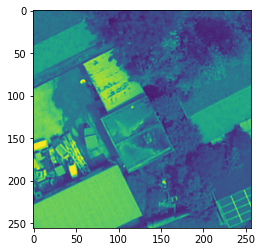

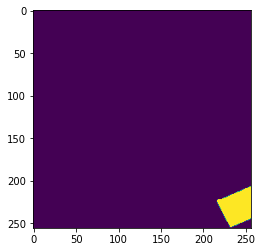

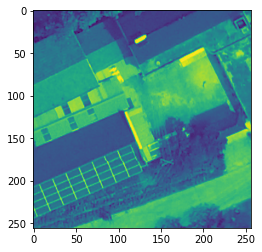

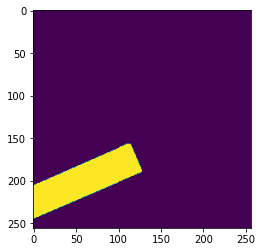

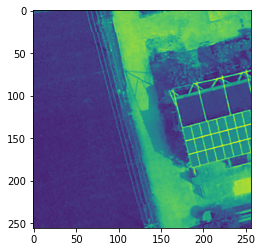

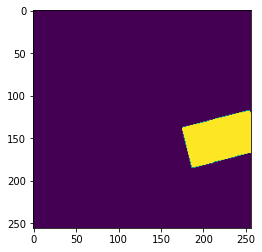

In [6]:
import cv2
for i in range(3):
  image = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
  plt.imshow(image)
  plt.show()
  mask = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)
  plt.imshow(mask)
  plt.show()

In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame(columns = ['path', 'mask_path', 'class'])
df['path'] = images
df['mask_path'] = masks
df['class'] = 1

df.head(10)

path  \
0  PV01/PV01_Rooftop_Brick/PV01_324942_1203839.bmp   
1  PV01/PV01_Rooftop_Brick/PV01_324942_1203842.bmp   
2  PV01/PV01_Rooftop_Brick/PV01_324951_1203793.bmp   
3  PV01/PV01_Rooftop_Brick/PV01_324951_1203795.bmp   
4  PV01/PV01_Rooftop_Brick/PV01_324956_1203801.bmp   
5  PV01/PV01_Rooftop_Brick/PV01_324956_1203803.bmp   
6  PV01/PV01_Rooftop_Brick/PV01_324958_1203801.bmp   
7  PV01/PV01_Rooftop_Brick/PV01_324958_1203803.bmp   
8  PV01/PV01_Rooftop_Brick/PV01_324972_1203798.bmp   
9  PV01/PV01_Rooftop_Brick/PV01_324972_1203801.bmp   

                                           mask_path  class  
0  PV01/PV01_Rooftop_Brick/PV01_324942_1203839_la...      1  
1  PV01/PV01_Rooftop_Brick/PV01_324942_1203842_la...      1  
2  PV01/PV01_Rooftop_Brick/PV01_324951_1203793_la...      1  
3  PV01/PV01_Rooftop_Brick/PV01_324951_1203795_la...      1  
4  PV01/PV01_Rooftop_Brick/PV01_324956_1203801_la...      1  
5  PV01/PV01_Rooftop_Brick/PV01_324956_1203803_la...      1  
6  PV01/PV01_Rooftop_Brick/PV01_324958_1203801_la...      1  
7  PV01/PV01_Rooftop_Brick/PV01_324958_1203803_la...      1  
8  PV01/PV01_Rooftop_Brick/PV01_324972_1203798_la...      1  
9  PV01/PV01_Rooftop_Brick/PV01_324972_1203801_la...      1

In [9]:
df0 = df
n=len(df)
df=df0.iloc[0:(n//10)*3]
test_df=df0.iloc[(n//10)*3:(n//10)*4]

In [10]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img


def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_bmp(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_bmp(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [13]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [15]:
def display(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image','True Mask','Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

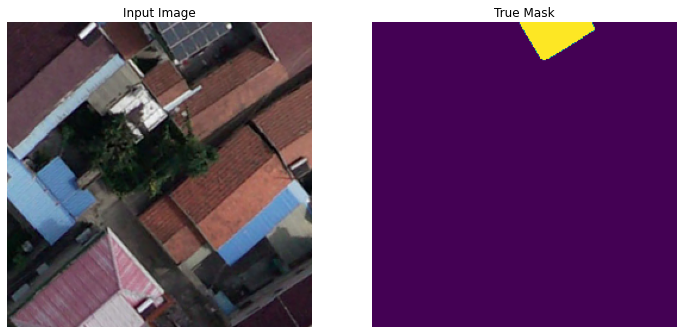

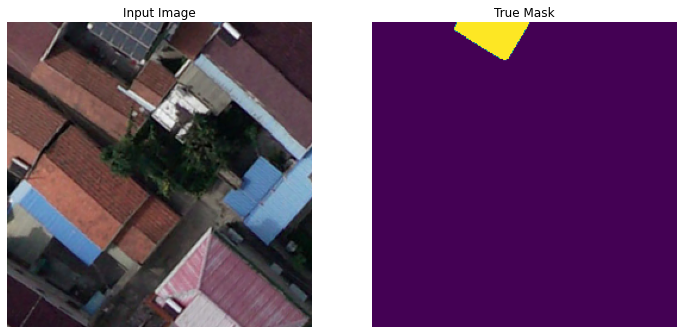

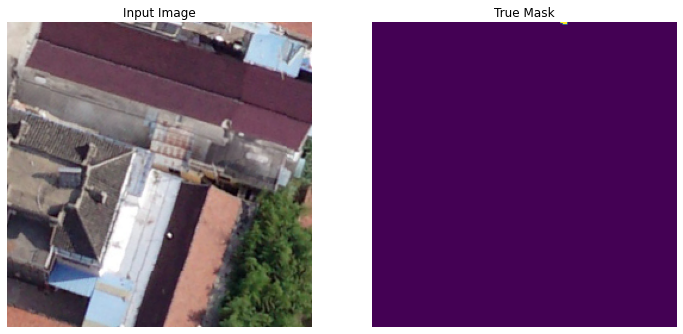

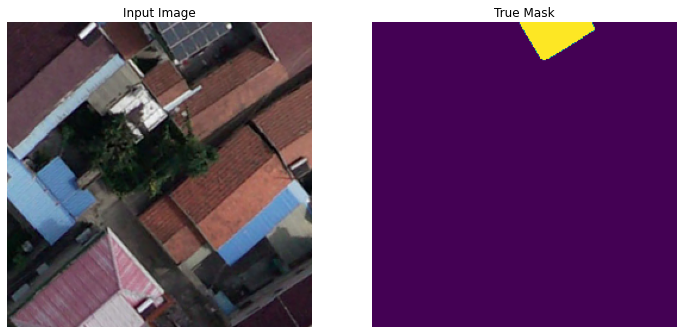

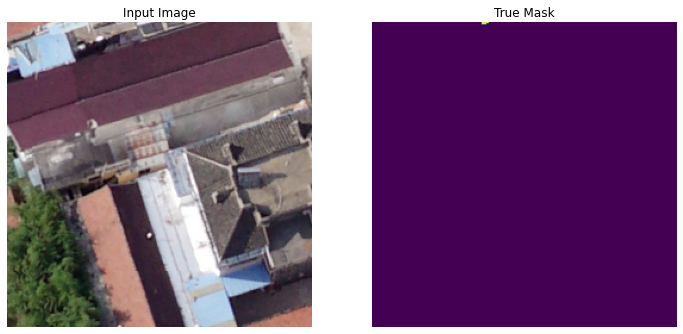

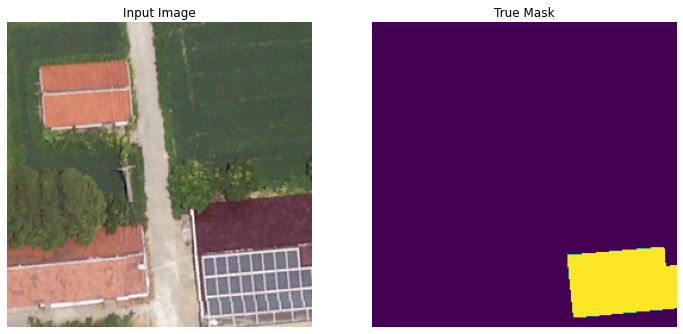

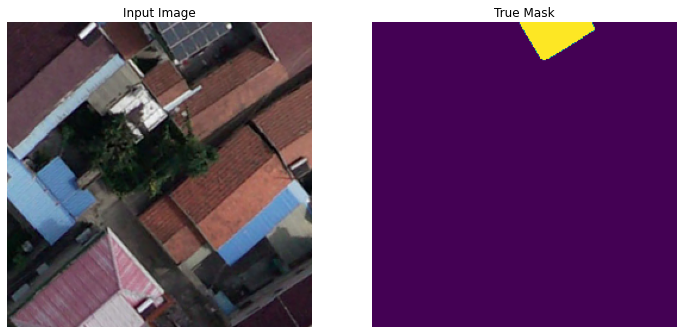

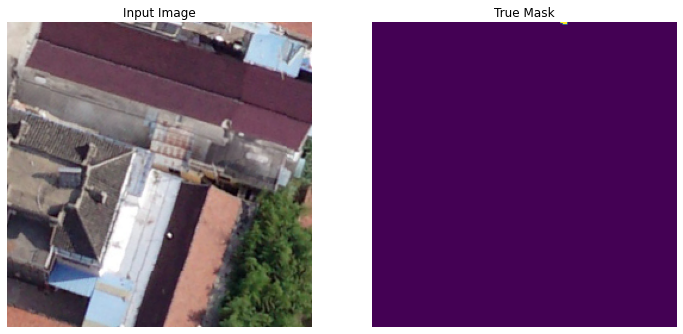

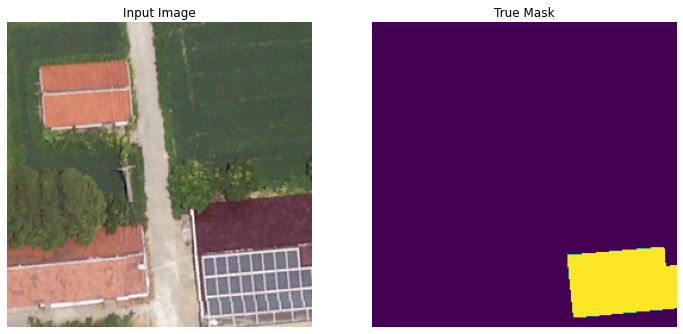

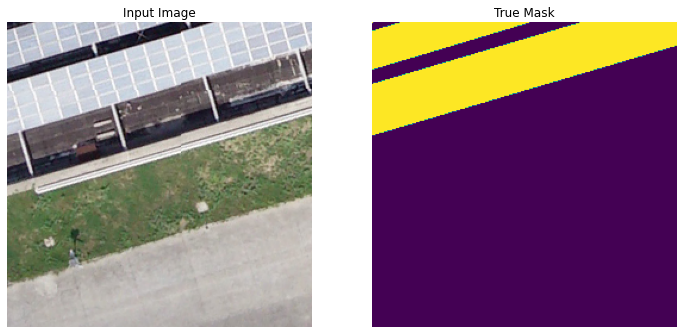

In [16]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

### DeepLabV3+

Reference: https://keras.io/examples/vision/deeplabv3_plus/

In [17]:
from keras import layers

In [18]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [19]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 2


In [20]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [21]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    predictions = model.predict(np.expand_dims((sample_image), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    pred_mask = predictions
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

In [22]:
import keras.backend as K

Epoch 1/150
 6/36 [====>.........................] - ETA: 10s - loss: 0.5321 - accuracy: 0.6273

36/36 [==============================] - 19s 404ms/step - loss: 0.3200 - accuracy: 0.8132 - val_loss: 0.6272 - val_accuracy: 0.8160
Epoch 2/150
1/1 [==============================] - 1s 788ms/step


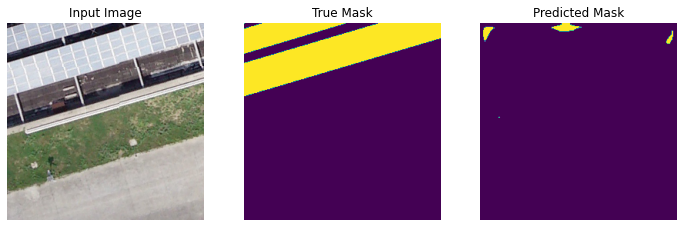

Epoch 3/150
36/36 [==============================] - 14s 392ms/step - loss: 0.1358 - accuracy: 0.9441 - val_loss: 0.4082 - val_accuracy: 0.8917
Epoch 4/150
36/36 [==============================] - 14s 385ms/step - loss: 0.0868 - accuracy: 0.9684 - val_loss: 0.3510 - val_accuracy: 0.8709
Epoch 5/150
1/1 [==============================] - 0s 22ms/step


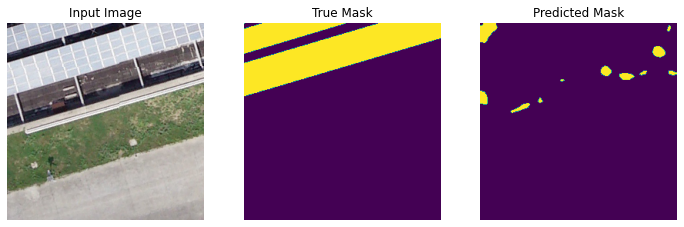

Epoch 6/150
36/36 [==============================] - 14s 392ms/step - loss: 0.0791 - accuracy: 0.9719 - val_loss: 0.6069 - val_accuracy: 0.8328
Epoch 7/150
36/36 [==============================] - 14s 385ms/step - loss: 0.0629 - accuracy: 0.9774 - val_loss: 2.5354 - val_accuracy: 0.7351
Epoch 8/150
1/1 [==============================] - 0s 35ms/step


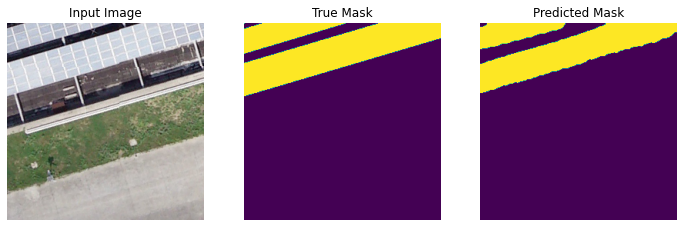

Epoch 9/150
36/36 [==============================] - 14s 387ms/step - loss: 0.0437 - accuracy: 0.9839 - val_loss: 0.1742 - val_accuracy: 0.9496
Epoch 10/150
36/36 [==============================] - 14s 386ms/step - loss: 0.0394 - accuracy: 0.9854 - val_loss: 0.1966 - val_accuracy: 0.9328
Epoch 11/150
1/1 [==============================] - 0s 22ms/step


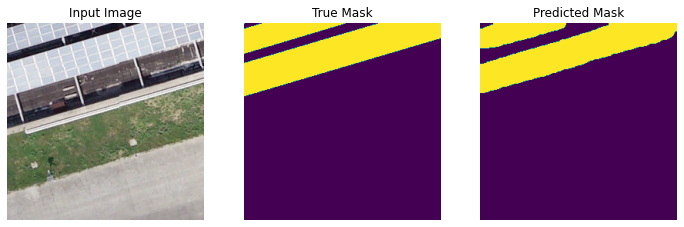

Epoch 12/150
36/36 [==============================] - 14s 385ms/step - loss: 0.0324 - accuracy: 0.9882 - val_loss: 0.2481 - val_accuracy: 0.9281
Epoch 13/150
36/36 [==============================] - 14s 386ms/step - loss: 0.0294 - accuracy: 0.9890 - val_loss: 0.2037 - val_accuracy: 0.9536
Epoch 14/150
1/1 [==============================] - 0s 22ms/step


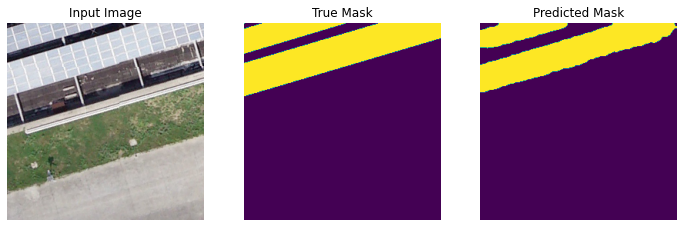

Epoch 15/150
36/36 [==============================] - 14s 386ms/step - loss: 0.0238 - accuracy: 0.9909 - val_loss: 0.1338 - val_accuracy: 0.9575
Epoch 16/150
36/36 [==============================] - 14s 396ms/step - loss: 0.0212 - accuracy: 0.9918 - val_loss: 0.1402 - val_accuracy: 0.9584
Epoch 17/150
1/1 [==============================] - 0s 23ms/step


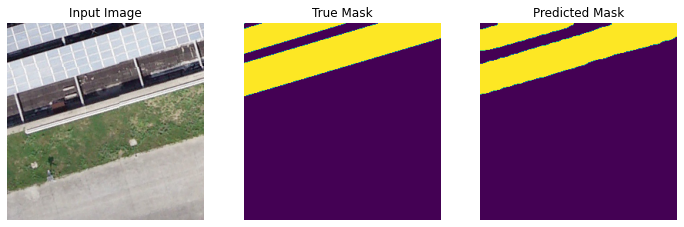

Epoch 18/150
36/36 [==============================] - 14s 387ms/step - loss: 0.0196 - accuracy: 0.9924 - val_loss: 0.0818 - val_accuracy: 0.9763
Epoch 19/150
36/36 [==============================] - 14s 387ms/step - loss: 0.0197 - accuracy: 0.9925 - val_loss: 0.0737 - val_accuracy: 0.9794
Epoch 20/150
1/1 [==============================] - 0s 22ms/step


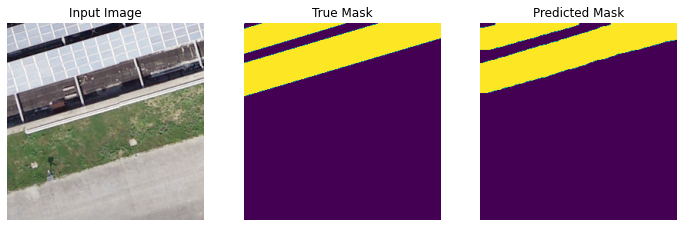

Epoch 21/150
36/36 [==============================] - 14s 397ms/step - loss: 0.0210 - accuracy: 0.9921 - val_loss: 0.3157 - val_accuracy: 0.9550
Epoch 22/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0262 - accuracy: 0.9898 - val_loss: 0.0504 - val_accuracy: 0.9825
Epoch 23/150
1/1 [==============================] - 0s 25ms/step


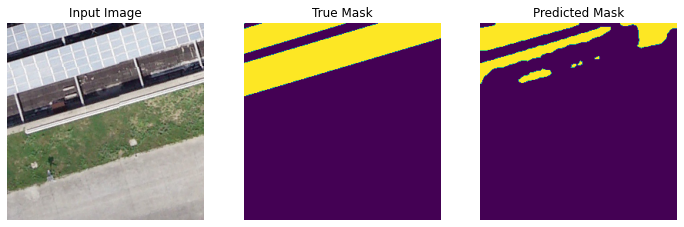

Epoch 24/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0168 - accuracy: 0.9933 - val_loss: 0.0662 - val_accuracy: 0.9801
Epoch 25/150
36/36 [==============================] - 14s 387ms/step - loss: 0.0165 - accuracy: 0.9934 - val_loss: 0.0524 - val_accuracy: 0.9824
Epoch 26/150
1/1 [==============================] - 0s 24ms/step


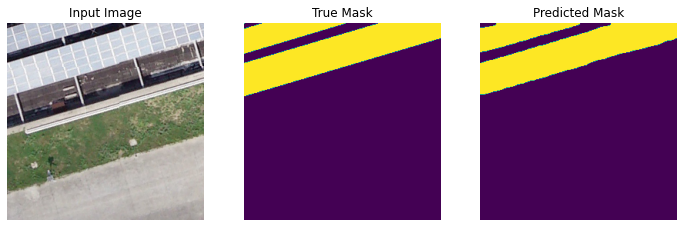

Epoch 27/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0177 - accuracy: 0.9929 - val_loss: 0.2555 - val_accuracy: 0.9621
Epoch 28/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0172 - accuracy: 0.9931 - val_loss: 0.0665 - val_accuracy: 0.9807
Epoch 29/150
1/1 [==============================] - 0s 22ms/step


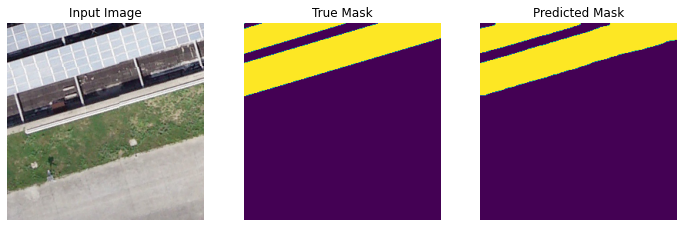

Epoch 30/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0138 - accuracy: 0.9944 - val_loss: 0.0526 - val_accuracy: 0.9851
Epoch 31/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0130 - accuracy: 0.9947 - val_loss: 0.0615 - val_accuracy: 0.9836
Epoch 32/150
1/1 [==============================] - 0s 22ms/step


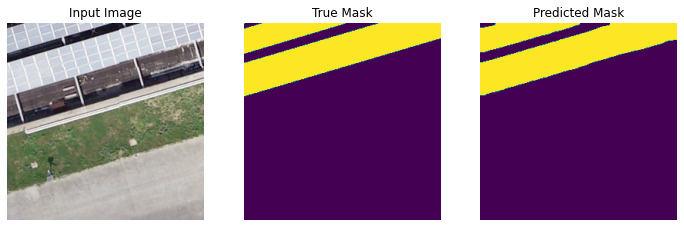

Epoch 33/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0119 - accuracy: 0.9952 - val_loss: 0.0646 - val_accuracy: 0.9841
Epoch 34/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0116 - accuracy: 0.9952 - val_loss: 0.0525 - val_accuracy: 0.9862
Epoch 35/150
1/1 [==============================] - 0s 21ms/step


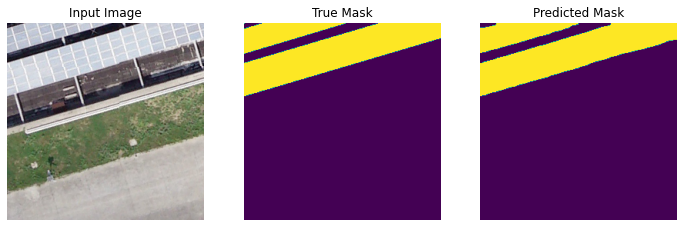

Epoch 36/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0121 - accuracy: 0.9951 - val_loss: 0.0977 - val_accuracy: 0.9747
Epoch 37/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0109 - accuracy: 0.9956 - val_loss: 0.0520 - val_accuracy: 0.9854
Epoch 38/150
1/1 [==============================] - 0s 33ms/step


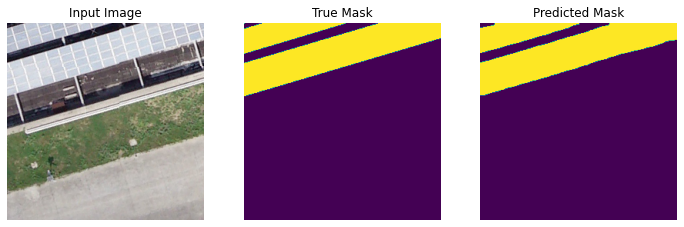

Epoch 39/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0106 - accuracy: 0.9957 - val_loss: 0.0532 - val_accuracy: 0.9862
Epoch 40/150
36/36 [==============================] - 14s 397ms/step - loss: 0.0106 - accuracy: 0.9957 - val_loss: 0.0514 - val_accuracy: 0.9859
Epoch 41/150
1/1 [==============================] - 0s 22ms/step


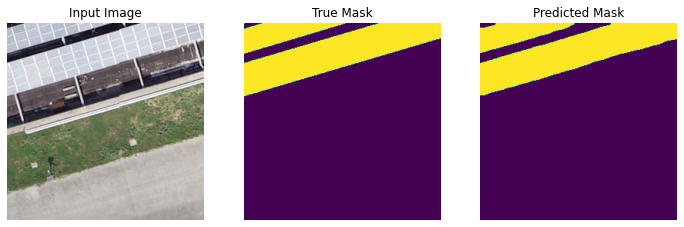

Epoch 42/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0093 - accuracy: 0.9962 - val_loss: 0.0667 - val_accuracy: 0.9846
Epoch 43/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0088 - accuracy: 0.9964 - val_loss: 0.0580 - val_accuracy: 0.9862
Epoch 44/150
1/1 [==============================] - 0s 22ms/step


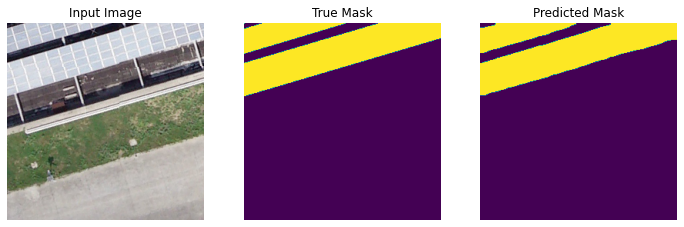

Epoch 45/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0633 - val_accuracy: 0.9852
Epoch 46/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0574 - val_accuracy: 0.9857
Epoch 47/150
1/1 [==============================] - 0s 21ms/step


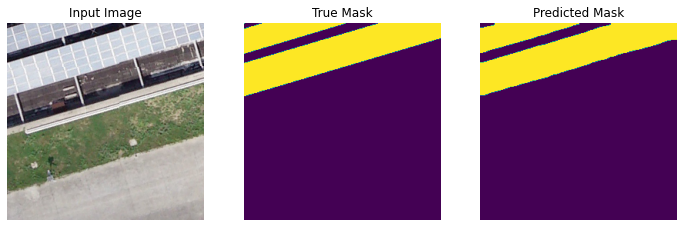

Epoch 48/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0079 - accuracy: 0.9967 - val_loss: 0.0607 - val_accuracy: 0.9860
Epoch 49/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.0483 - val_accuracy: 0.9871
Epoch 50/150
1/1 [==============================] - 0s 22ms/step


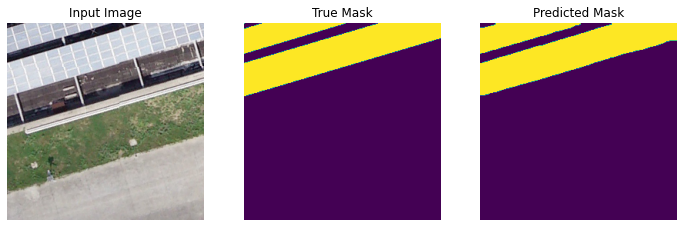

Epoch 51/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 0.0593 - val_accuracy: 0.9859
Epoch 52/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0073 - accuracy: 0.9970 - val_loss: 0.0526 - val_accuracy: 0.9865
Epoch 53/150
1/1 [==============================] - 0s 21ms/step


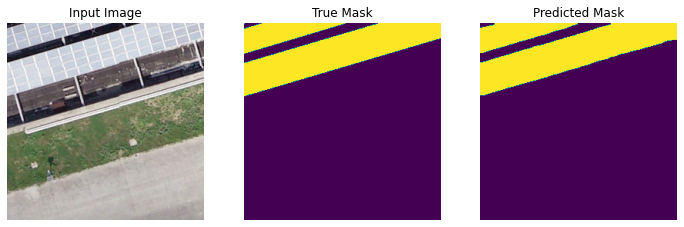

Epoch 54/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.0578 - val_accuracy: 0.9859
Epoch 55/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0064 - accuracy: 0.9974 - val_loss: 0.0648 - val_accuracy: 0.9856
Epoch 56/150
1/1 [==============================] - 0s 22ms/step


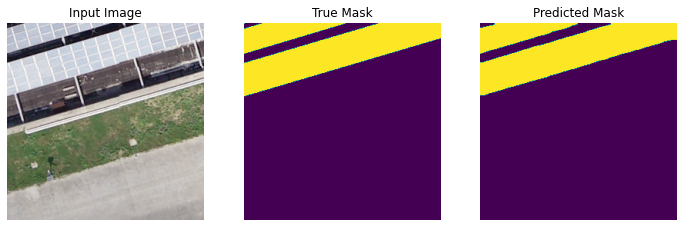

Epoch 57/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0078 - accuracy: 0.9969 - val_loss: 0.0737 - val_accuracy: 0.9849
Epoch 58/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 59.1772 - val_accuracy: 0.8284
Epoch 59/150
1/1 [==============================] - 0s 22ms/step


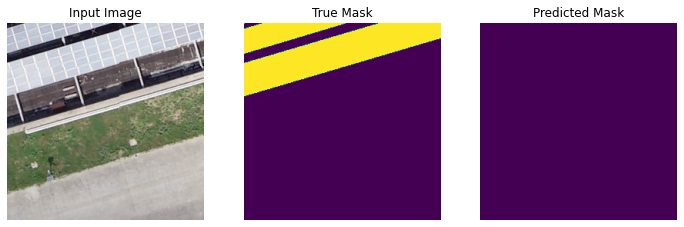

Epoch 60/150
36/36 [==============================] - 14s 398ms/step - loss: 0.0194 - accuracy: 0.9924 - val_loss: 1.7011 - val_accuracy: 0.9369
Epoch 61/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0136 - accuracy: 0.9946 - val_loss: 0.2102 - val_accuracy: 0.9541
Epoch 62/150
1/1 [==============================] - 0s 22ms/step


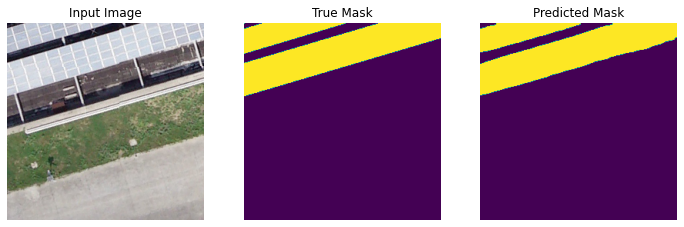

Epoch 63/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0106 - accuracy: 0.9956 - val_loss: 0.0696 - val_accuracy: 0.9817
Epoch 64/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 0.0767 - val_accuracy: 0.9812
Epoch 65/150
1/1 [==============================] - 0s 20ms/step


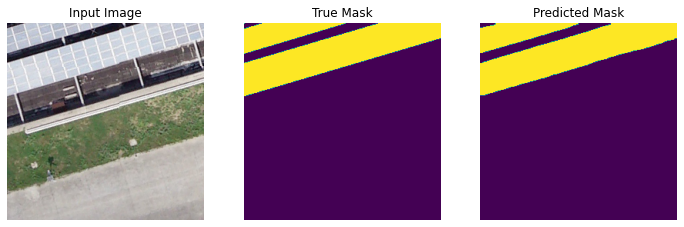

Epoch 66/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0088 - accuracy: 0.9963 - val_loss: 0.0804 - val_accuracy: 0.9827
Epoch 67/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0864 - val_accuracy: 0.9821
Epoch 68/150
1/1 [==============================] - 0s 24ms/step


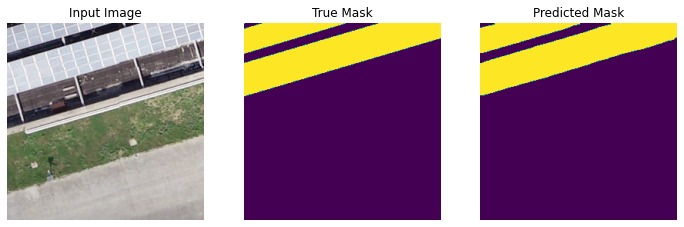

Epoch 69/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0084 - accuracy: 0.9965 - val_loss: 0.0782 - val_accuracy: 0.9810
Epoch 70/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0072 - accuracy: 0.9970 - val_loss: 0.0784 - val_accuracy: 0.9833
Epoch 71/150
1/1 [==============================] - 0s 25ms/step


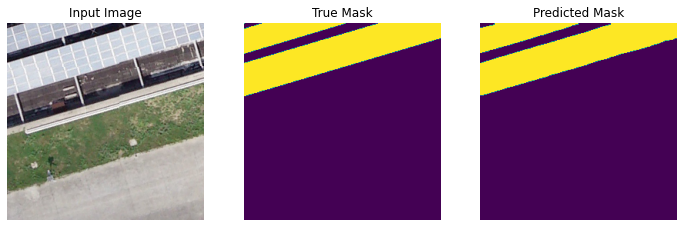

Epoch 72/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0069 - accuracy: 0.9972 - val_loss: 0.0726 - val_accuracy: 0.9842
Epoch 73/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0066 - accuracy: 0.9972 - val_loss: 0.0702 - val_accuracy: 0.9849
Epoch 74/150
1/1 [==============================] - 0s 23ms/step


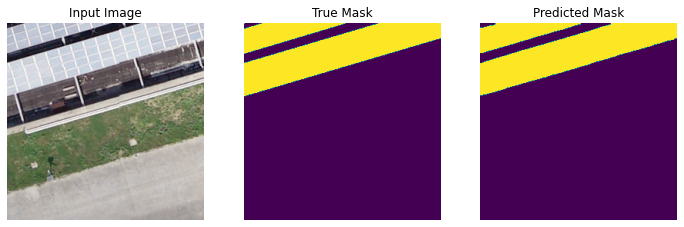

Epoch 75/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0728 - val_accuracy: 0.9847
Epoch 76/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0724 - val_accuracy: 0.9845
Epoch 77/150
1/1 [==============================] - 0s 21ms/step


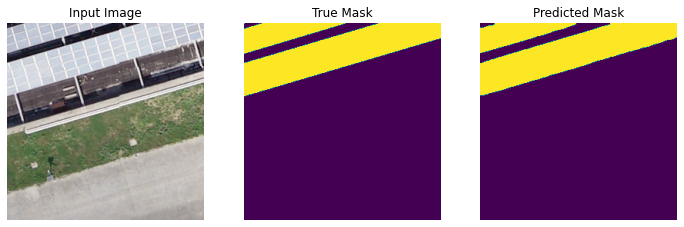

Epoch 78/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0756 - val_accuracy: 0.9850
Epoch 79/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0756 - val_accuracy: 0.9846
Epoch 80/150
1/1 [==============================] - 0s 21ms/step


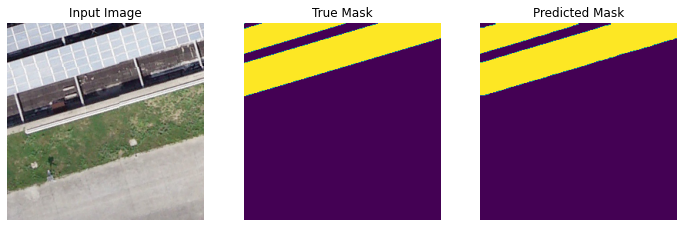

Epoch 81/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0690 - val_accuracy: 0.9853
Epoch 82/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.0633 - val_accuracy: 0.9857
Epoch 83/150
1/1 [==============================] - 0s 22ms/step


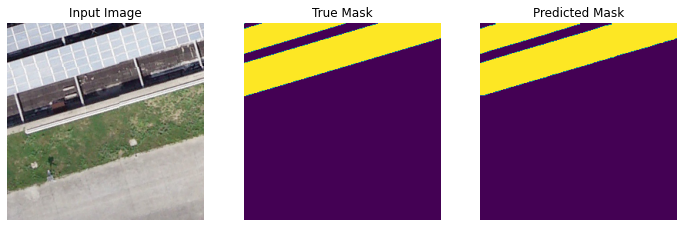

Epoch 84/150
36/36 [==============================] - 14s 397ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0708 - val_accuracy: 0.9855
Epoch 85/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0793 - val_accuracy: 0.9846
Epoch 86/150
1/1 [==============================] - 0s 23ms/step


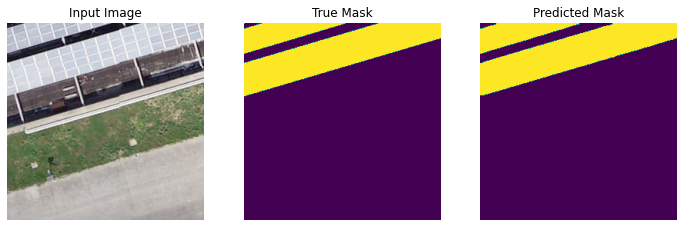

Epoch 87/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0781 - val_accuracy: 0.9856
Epoch 88/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0046 - accuracy: 0.9981 - val_loss: 0.0763 - val_accuracy: 0.9856
Epoch 89/150
1/1 [==============================] - 0s 21ms/step


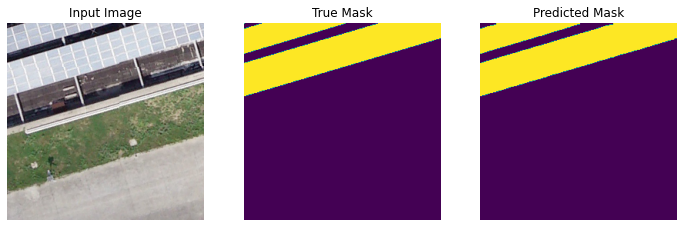

Epoch 90/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.0768 - val_accuracy: 0.9853
Epoch 91/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.0839 - val_accuracy: 0.9850
Epoch 92/150
1/1 [==============================] - 0s 23ms/step


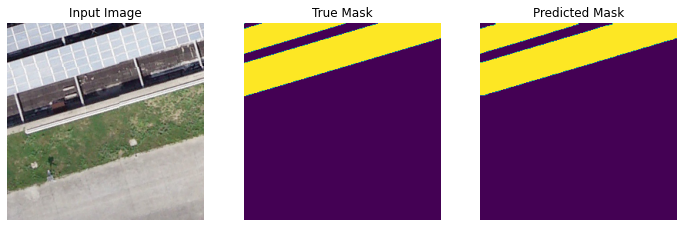

Epoch 93/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 0.0966 - val_accuracy: 0.9844
Epoch 94/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0045 - accuracy: 0.9981 - val_loss: 0.0913 - val_accuracy: 0.9849
Epoch 95/150
1/1 [==============================] - 0s 24ms/step


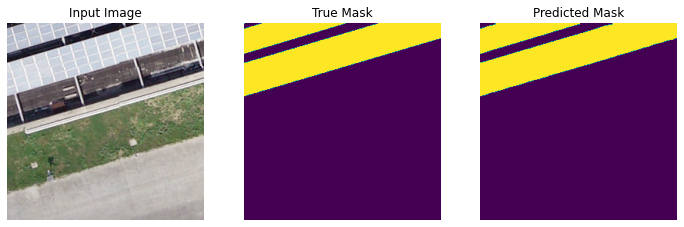

Epoch 96/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0804 - val_accuracy: 0.9853
Epoch 97/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0801 - val_accuracy: 0.9852
Epoch 98/150
1/1 [==============================] - 0s 21ms/step


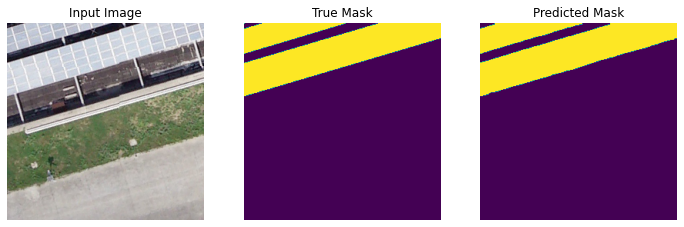

Epoch 99/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0177 - accuracy: 0.9932 - val_loss: 0.9556 - val_accuracy: 0.8654
Epoch 100/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0201 - accuracy: 0.9921 - val_loss: 0.4318 - val_accuracy: 0.9590
Epoch 101/150
1/1 [==============================] - 0s 22ms/step


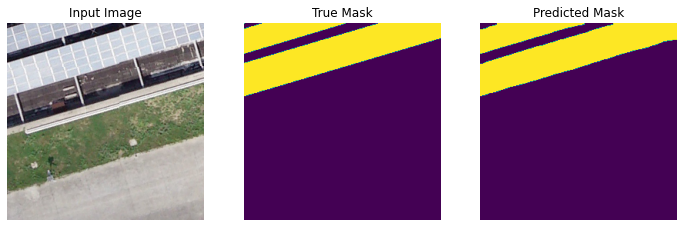

Epoch 102/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0761 - val_accuracy: 0.9830
Epoch 103/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0931 - val_accuracy: 0.9817
Epoch 104/150
1/1 [==============================] - 0s 24ms/step


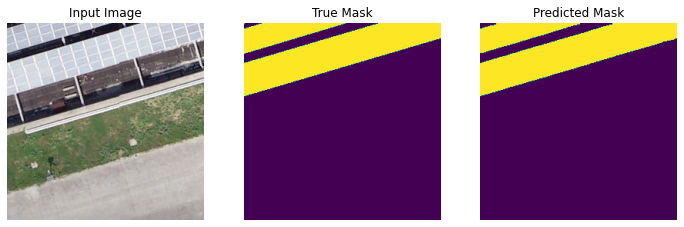

Epoch 105/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0046 - accuracy: 0.9981 - val_loss: 0.0950 - val_accuracy: 0.9818
Epoch 106/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0046 - accuracy: 0.9981 - val_loss: 0.1006 - val_accuracy: 0.9814
Epoch 107/150
1/1 [==============================] - 0s 25ms/step


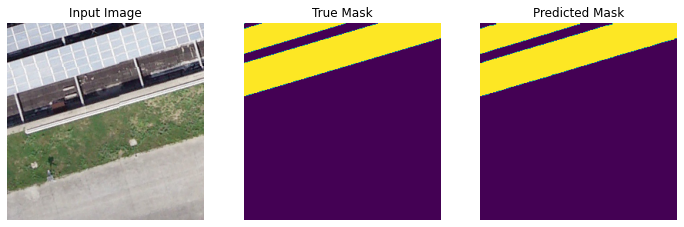

Epoch 108/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.0984 - val_accuracy: 0.9823
Epoch 109/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.1102 - val_accuracy: 0.9821
Epoch 110/150
1/1 [==============================] - 0s 33ms/step


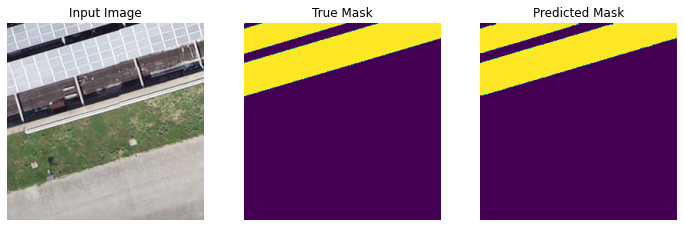

Epoch 111/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 0.1054 - val_accuracy: 0.9828
Epoch 112/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.1136 - val_accuracy: 0.9824
Epoch 113/150
1/1 [==============================] - 0s 26ms/step


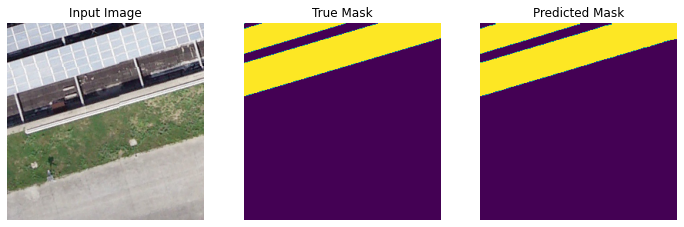

Epoch 114/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.1618 - val_accuracy: 0.9714
Epoch 115/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0288 - accuracy: 0.9905 - val_loss: 0.6960 - val_accuracy: 0.8091
Epoch 116/150
1/1 [==============================] - 0s 34ms/step


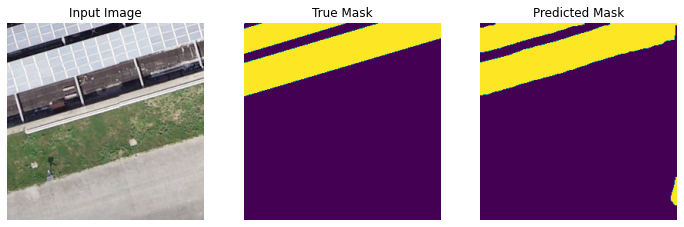

Epoch 117/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0869 - val_accuracy: 0.9743
Epoch 118/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0067 - accuracy: 0.9973 - val_loss: 0.0646 - val_accuracy: 0.9815
Epoch 119/150
1/1 [==============================] - 0s 23ms/step


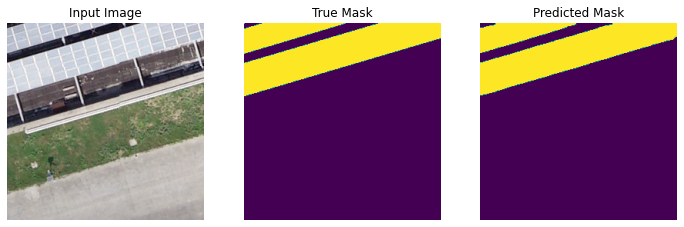

Epoch 120/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0662 - val_accuracy: 0.9833
Epoch 121/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0725 - val_accuracy: 0.9833
Epoch 122/150
1/1 [==============================] - 0s 26ms/step


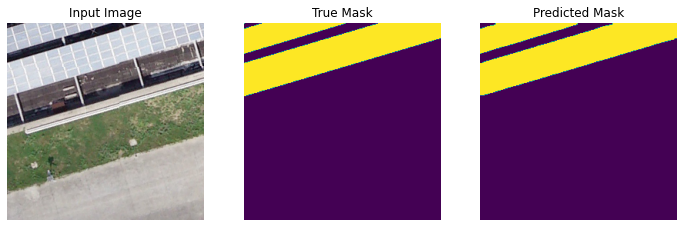

Epoch 123/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0041 - accuracy: 0.9983 - val_loss: 0.0724 - val_accuracy: 0.9838
Epoch 124/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0769 - val_accuracy: 0.9833
Epoch 125/150
1/1 [==============================] - 0s 26ms/step


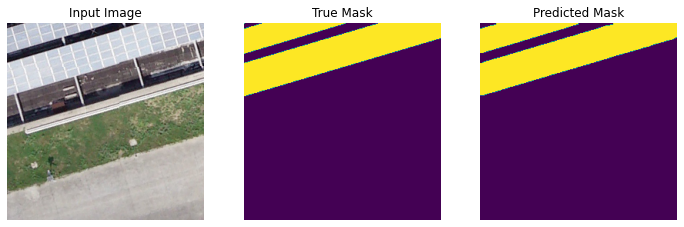

Epoch 126/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0807 - val_accuracy: 0.9838
Epoch 127/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 0.0830 - val_accuracy: 0.9835
Epoch 128/150
1/1 [==============================] - 0s 28ms/step


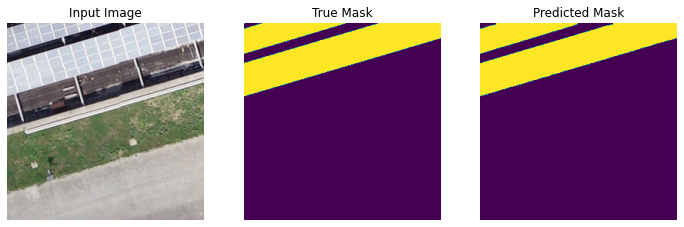

Epoch 129/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.0853 - val_accuracy: 0.9840
Epoch 130/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.0868 - val_accuracy: 0.9841
Epoch 131/150
1/1 [==============================] - 0s 23ms/step


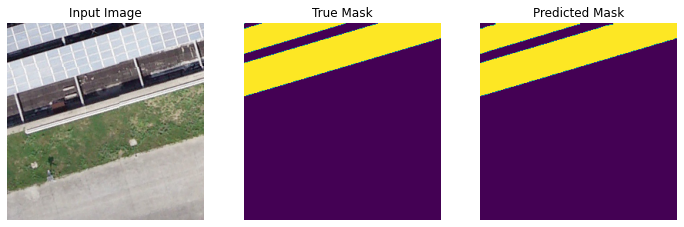

Epoch 132/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0807 - val_accuracy: 0.9846
Epoch 133/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0851 - val_accuracy: 0.9846
Epoch 134/150
1/1 [==============================] - 0s 26ms/step


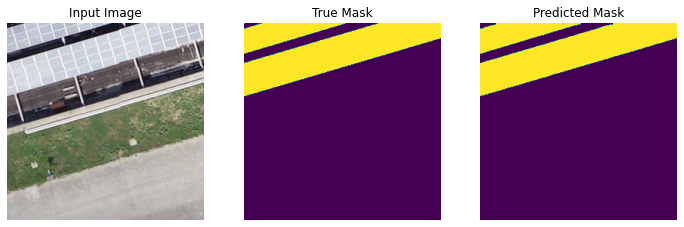

Epoch 135/150
36/36 [==============================] - 14s 398ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0884 - val_accuracy: 0.9841
Epoch 136/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0874 - val_accuracy: 0.9843
Epoch 137/150
1/1 [==============================] - 0s 31ms/step


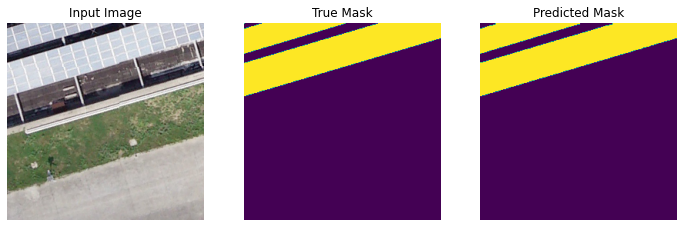

Epoch 138/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0946 - val_accuracy: 0.9840
Epoch 139/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.1013 - val_accuracy: 0.9839
Epoch 140/150
1/1 [==============================] - 0s 32ms/step


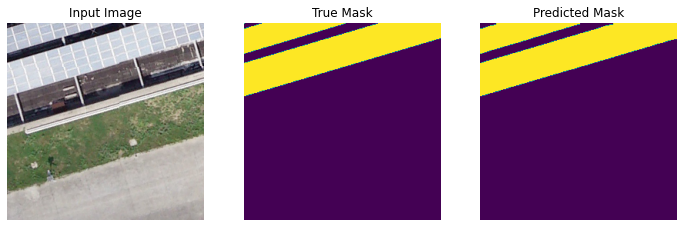

Epoch 141/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.1009 - val_accuracy: 0.9836
Epoch 142/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.1017 - val_accuracy: 0.9836
Epoch 143/150
1/1 [==============================] - 0s 32ms/step


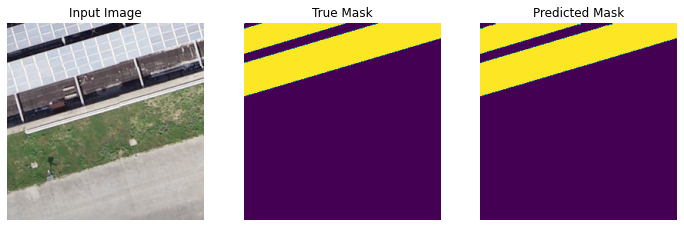

Epoch 144/150
36/36 [==============================] - 14s 389ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.0984 - val_accuracy: 0.9845
Epoch 145/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0926 - val_accuracy: 0.9848
Epoch 146/150
1/1 [==============================] - 0s 31ms/step


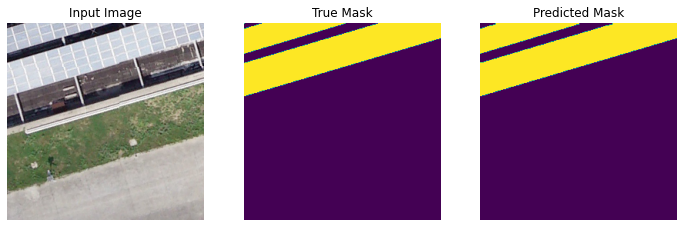

Epoch 147/150
36/36 [==============================] - 14s 390ms/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0989 - val_accuracy: 0.9843
Epoch 148/150
36/36 [==============================] - 14s 391ms/step - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.1011 - val_accuracy: 0.9842
Epoch 149/150
1/1 [==============================] - 0s 34ms/step


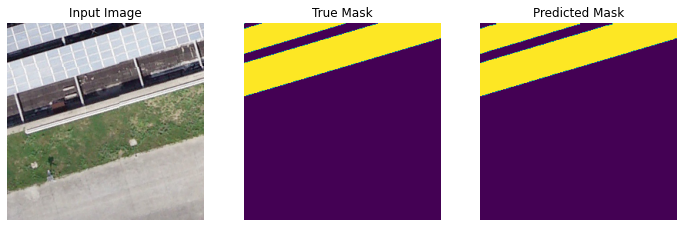

Epoch 150/150
36/36 [==============================] - 14s 388ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0951 - val_accuracy: 0.9848


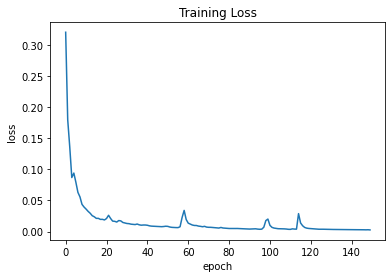

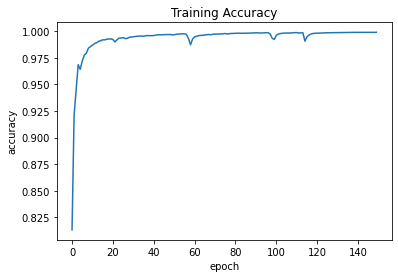

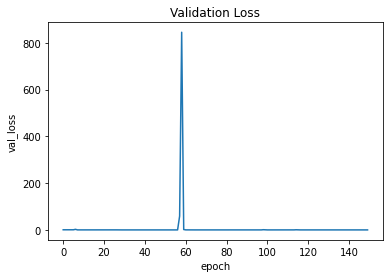

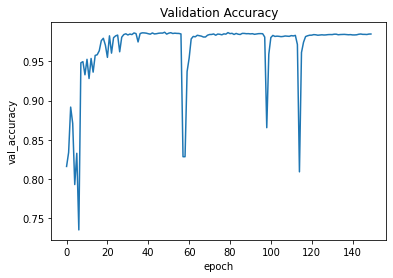

In [24]:
EPOCHS = 150
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)


history = model.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH,
 validation_data=valid_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


Evaluation:

35m 27s on a Google Compute Engine GPU.

Accuracy: 99.90% - Validation Accuracy 98.48% 

In [25]:
model.save('deeplabv3.h5')